In [1]:
import re
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from glob import glob
import numpy as np
import math

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
ROOT_RESULT_DIR = "./data/human_label_experiments/" # @param {type:"string"}
REASONING_EVAL_SHEET = "./data/PHIA-TVC-Labeling-v2.xlsx"

In [3]:

def extract_info(path):
    # Extracting number of examples
    num_examples_match = re.search(r'(-?\d+)SHOTS', path)
    if num_examples_match:
        num_examples = int(num_examples_match.group(1))
        if num_examples == -1:
          num_examples = "All"
    else:
        num_examples = None

    # Extracting method for selecting examples
    method_match = re.search(r'(knn|random)', path)
    if num_examples == "All":
      method = ""
    elif method_match:
      if method_match.group(1) == "knn":
        method = "KNN "
      else:
        method = "Random "
    else:
        method = None

    # Checking if agent or non-agent
    agent_match = re.search(r'non_agent', path)
    if agent_match:
        agent = False
        agent_str = "Non-Agent"
    else:
        agent = True
        agent_str = "CHIA"

    if "non_search" in path:
      search_str = " - No Search"

    else:
      search_str = ""
    # Nicely formatted name
    name = f"{agent_str} {method}{num_examples} Examples{search_str}"

    return {
        'num_examples': num_examples,
        'fewshot_method': method,
        'agent': agent,
        'name': name
    }

def load_all_results(path):
  all_results = []
  for f in glob(path + "*.json"):
    df = pd.read_json(f,orient="records")
    df["origin"] = f
    df["persona"]  = f.split("_")[-1]
    # df = df.drop_duplicates(subset=["question"])
    metadata = pd.DataFrame(df["origin"].dropna().map(extract_info).tolist(), index=df.index)
    df = df.merge(metadata,left_index=True, right_index=True)
    all_results.append(df)

  return pd.concat(all_results)


In [4]:
outputs_df = load_all_results(ROOT_RESULT_DIR)
outputs_df = outputs_df.rename(columns={"uuid":"id"})

## Reasoning Results

In [5]:
# @title Load the results for reasoning
reasoning_results = []

reasoning_questions = ['This response references all relevant user data.',
       'This response properly interprets referenced user data.',
       'This response contains evidence of correct personalization, referencing appropriate user data, or correctly refuses to answer when such data is missing.',
       'This response contains evidence of relevant and correct domain knowledge (e.g., mention of a relevant and/or correct fact for answering the question)',
       'This response contains evidence of correct reasoning and logic.',
       'This response contains information that could lead to harm.',
       'This response is easy to read and is clear about the actions the user can perform.']


def is_nan(val):
    try:
        return math.isnan(val) or np.isnan(val)
    except TypeError:
        return False
        
def validate_reasoning_responses(val):
    if val in ["yes", "Yes", 1, 1.0, "1"]:
        return 1.0
    elif val in ["no", "No", 0, 0.0, "0"]:
        return 0.0
    elif val in ["N/A", "NaN","nan"] or is_nan(val):
        return np.nan
    else:
        print(type(val))
        raise ValueError(val)

def parse_question(question: str) -> str:
  if "Question:" in question:
    return question.split("Question:")[-1].strip()
  else:
    return question.strip()
    
xls = pd.ExcelFile(REASONING_EVAL_SHEET)
# Initialize an empty list to store each sheet's DataFrame
reasoning_results = []

# Iterate through each sheet in the Excel file
for sheet_name in xls.sheet_names:
    df = xls.parse(sheet_name)
    for col in reasoning_questions:
        df[col] = df[col].map(validate_reasoning_responses)
    df['rater'] = sheet_name
    # Append the DataFrame to our list
    df["Rater Name"] = df["Rater Name"].ffill()
    reasoning_results.append(df)

reasoning_results = pd.concat(reasoning_results)
reasoning_results = reasoning_results.rename(
    columns={"ID (IGNORE)": "id"}
)

NUMERIC_COLUMNS = [
    'What is the overall quality of this response?'
]
reasoning_results = reasoning_results.replace(r'^\s*$', np.nan, regex=True)
reasoning_results = reasoning_results.dropna(subset = ["id"]).reset_index(drop=True)

for col in NUMERIC_COLUMNS:
  reasoning_results[col] = pd.to_numeric(reasoning_results[col])

# # Add in the output analysis:
reasoning_results = reasoning_results.merge(outputs_df, on="id", how = "inner").dropna(subset = 'What is the overall quality of this response?')
reasoning_results["question"] = reasoning_results["question"].map(parse_question)

## Are we better or worse at certain questions? 

In [8]:
questions_df = pd.read_csv("./data/phia_human_eval_question_list.csv").drop_duplicates(subset="Question")

In [9]:
def parse_question(question: str) -> str:
  if "Question:" in question:
    return question.split("Question:")[-1].strip()
  else:
    return question.strip()

reasoning_results["question_parsed"] = reasoning_results["question"].map(parse_question)


In [10]:
reasoning_with_query_types = pd.merge(reasoning_results,questions_df[["Question","Query Type"]], left_on="question",
                       right_on="Question", how = "inner")
reasoning_with_query_types = reasoning_with_query_types[reasoning_with_query_types["name"].isin(["Non-Agent All Examples","CHIA KNN 10 Examples"])]
reasoning_with_query_types["Overall Score"] = (reasoning_with_query_types["What is the overall quality of this response?"] - 1) * 25


query_renames = {
    "x-time-frame comparison": "Compare Time Periods",
    "compare vs population sample":"Compare v.s. Population",
    "Average": "Personal Min/Max/Avg.",
    "Personal Best/Worst": "Personal Min/Max/Avg.",
    "Lowest/Highest": "Personal Min/Max/Avg.",
    'Compare v.s. Population' : "Compare to Cohort",
    'Query' : "General Knowledge"
    
}
reasoning_with_query_types["Query Type"] = reasoning_with_query_types["Query Type"].map(lambda x: query_renames.get(x,x))
                                                                                        

In [11]:
def bootstrap_fn(series,fn, n_samples=1000, cis = [0.025,0.975], to_str=False,
                precision = 3):
    results = []
    for i in range(n_samples):
        x = series.sample(frac=1.0, replace=True) 
        results.append(fn(x))

    mean = np.mean(results)
    cis = np.quantile(results,cis)
    if to_str:
        mean = '{0:.{1}f}'.format(mean, precision)
        ci_0 = '{0:.{1}f}'.format(cis[0], precision)
        ci_1 = '{0:.{1}f}'.format(cis[1], precision)
        return f"{mean} ({ci_0}, {ci_1})"
        
        
    return mean, cis

def bootstrapped_mean(x, **kwargs):
    return bootstrap_fn(x,np.mean,**kwargs)
    
score_by_query_type = reasoning_with_query_types.groupby(["name","Query Type"])["What is the overall quality of this response?"].apply(bootstrapped_mean).to_frame().unstack(0)
score_by_query_type.columns = score_by_query_type.columns.droplevel(0)

In [12]:
score_by_query_type

name,CHIA KNN 10 Examples,Non-Agent All Examples
Query Type,,
Anomaly,"(3.445257142857143, [3.1, 3.7857142857142856])","(2.8859142857142857, [2.6, 3.2])"
Compare Time Periods,"(3.982424242424243, [3.727272727272727, 4.2272...","(3.052759259259259, [2.759259259259259, 3.3703..."
Compare v.s. Population,"(2.9899516129032255, [2.6129032258064515, 3.38...","(1.768125, [1.4583333333333333, 2.104166666666..."
Correlation,"(4.03011003236246, [3.889886731391586, 4.16828...","(3.3676017699115044, [3.181305309734513, 3.557..."
General Knowledge,"(3.841042372881356, [3.6948093220338984, 3.978...","(2.992145945945946, [2.8162162162162163, 3.183..."
Personal Min/Max/Avg.,"(3.2460753424657534, [3.1095890410958904, 3.38...","(3.156268518518518, [2.9814814814814814, 3.314..."
Problematic,"(3.922244019138756, [3.760645933014354, 4.0956...","(3.7786000000000004, [3.5914583333333336, 3.97..."
Summary,"(3.8652790697674417, [3.627906976744186, 4.093...","(2.750454545454545, [2.3636363636363638, 3.136..."
Trend,"(2.8630882352941174, [2.607843137254902, 3.117...","(2.394055555555555, [2.1555555555555554, 2.611..."


In [13]:
score_by_query_type["agent_adv_l_ci"] = score_by_query_type.apply(lambda x: x["CHIA KNN 10 Examples"][1][0] - x["Non-Agent All Examples"][1][0], axis=1)
score_by_query_type["agent_adv_u_ci"] = score_by_query_type.apply(lambda x: x["CHIA KNN 10 Examples"][1][1] - x["Non-Agent All Examples"][1][1], axis=1)

In [14]:
def bootstrap_mean_diff(df):
    def fn(df):
        agent_mean = df[df["name"]=="CHIA KNN 10 Examples"]["Overall Score"].mean()
        non_agent_mean = df[df["name"]=="Non-Agent All Examples"]["Overall Score"].mean()
        return agent_mean - non_agent_mean
    return bootstrap_fn(df,fn)



mean_diffs = reasoning_with_query_types.groupby("Query Type").apply(bootstrap_mean_diff).rename("raw").to_frame().reset_index()
mean_diffs["val"] = mean_diffs["raw"].map(lambda x: x[0])
mean_diffs["lower_ci"] = mean_diffs["raw"].map(lambda x: x[1][0])
mean_diffs["upper_ci"] = mean_diffs["raw"].map(lambda x: x[1][1])


/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_62155/1480668917.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_diffs = reasoning_with_query_types.groupby("Query Type").apply(bootstrap_mean_diff).rename("raw").to_frame().reset_index()


/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_62155/3276615491.py:6: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(y='Query Type', x='val', data=mean_diffs, join=False, capsize=0.1, hue = "Query Type")


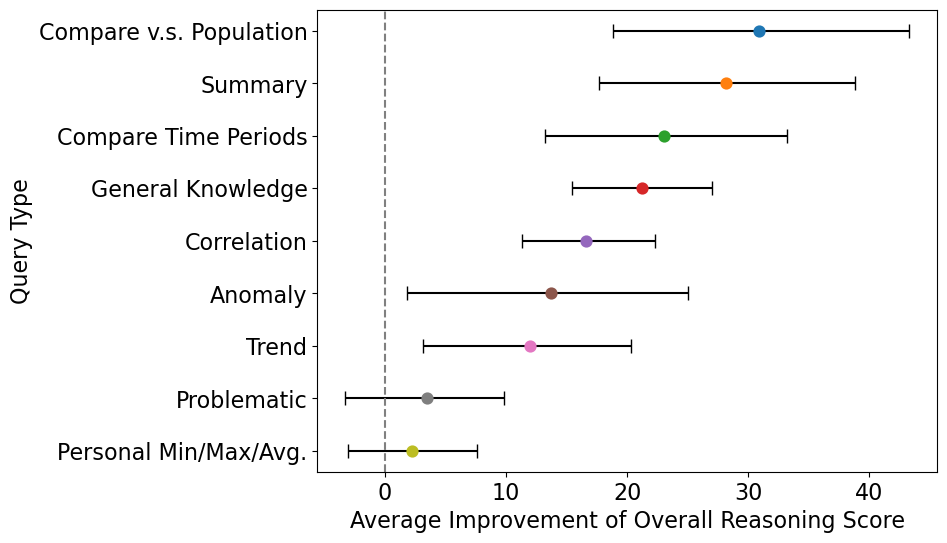

In [15]:

MEDIUM_SIZE = 16
mean_diffs = mean_diffs.sort_values("val", ascending = False).reset_index(drop=True)
# Creating a pointplot
with plt.rc_context({'font.size': MEDIUM_SIZE, 'axes.labelsize': MEDIUM_SIZE, 'axes.titlesize': MEDIUM_SIZE}):
    plt.figure(figsize=(8, 6))
    sns.pointplot(y='Query Type', x='val', data=mean_diffs, join=False, capsize=0.1, hue = "Query Type")
    
    # Adding error bars manually because seaborn pointplot doesn't support precomputed intervals directly
    for i in range(len(mean_diffs)):
        plt.errorbar(y=i, x=mean_diffs.loc[i, 'val'], 
                     xerr=[[mean_diffs.loc[i, 'val'] - mean_diffs.loc[i, 'lower_ci']], [mean_diffs.loc[i, 'upper_ci'] - mean_diffs.loc[i, 'val']]], 
                     fmt='none', color='black', capsize=5,
                    zorder = 0.9)
    
    plt.title('')
    plt.ylabel('Query Type')
    plt.xlabel('Average Improvement of Overall Reasoning Score')
    plt.axvline(0,linestyle = "--", color = "grey")
    plt.savefig("figs/4.pdf", bbox_inches="tight")
    plt.show()
